In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pymorphy3

from nltk.corpus import stopwords
from tqdm.auto import tqdm
from wordcloud import WordCloud
from collections import Counter

/home/alex/.cache/pypoetry/virtualenvs/aviation-topic-pipeline-XD-grrq7-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
aeroflot = pd.read_csv('../data/raw/aeroflot_official_posts.csv')
aviatorshina = pd.read_csv('../data/raw/aviatorshina_posts.csv')
favt = pd.read_csv('../data/raw/favt_ru_posts.csv')
s7 = pd.read_csv('../data/raw/s7newsroom_posts.csv')
avia_comments = pd.read_csv('../data/raw/AviaComments_posts.csv')
rumayday = pd.read_csv('../data/raw/rumayday_posts.csv')
aviationmode = pd.read_csv('../data/raw/aviationmode_posts.csv')

**Объединие данных из каналов в один датафрейм**

In [5]:
df = pd.concat([aeroflot, aviatorshina, favt, s7, avia_comments, rumayday, aviationmode], axis=0)
df.head()

,message
0,"Поздравляем, самые любимые 💙\n\nВы научили нас..."
1,☀️ Как победить сезонную хандру? \n\nУчастники...
2,👦На борту наших рейсов юные пассажиры ведут се...
3,❄️ Только представьте: полёт в сопровождении о...
4,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...


In [6]:
len(df)

10456

**Удаление пустых значений**

In [7]:
df.isnull().sum()

message    4814
dtype: int64

In [8]:
df = df.dropna()

In [9]:
len(df)

5642

**Обработка дубликатов**

In [10]:
np.sum(df.duplicated())

np.int64(60)

In [11]:
df[df.duplicated]

,message
1851,Актуальные новости мира БАС: В Беларуси физлиц...
1613,#Мнение_экспертов — старшего научного сотрудни...
7,✈️Замруководителя Росавиации Сергей Страмоус п...
116,✈️Статус работ сразу по трем самолетам УЗГА ра...
154,Росавиация аннулирует сертификат эксплуатанта ...
216,✈️ Открыли памятник «Красный Кут — город авиат...
251,Завершаем юбилейные празднования завораживающи...
261,С чего началось празднование 90-летия УИ ГА? С...
287,✈️ Росавиация уведомила российских эксплуатант...
291,✈️Краснодарский аэропорт с 09:00 МСК 11 сентяб...


In [12]:
df = df.drop_duplicates(keep='first')

In [13]:
len(df)

5582

**Анализ длин постов**

In [14]:
df['message_lenght'] = df['message'].apply(lambda x: len(x))
df['word_count'] = df['message'].str.split().str.len()

Text(0.5, 0, 'messages_lenght')

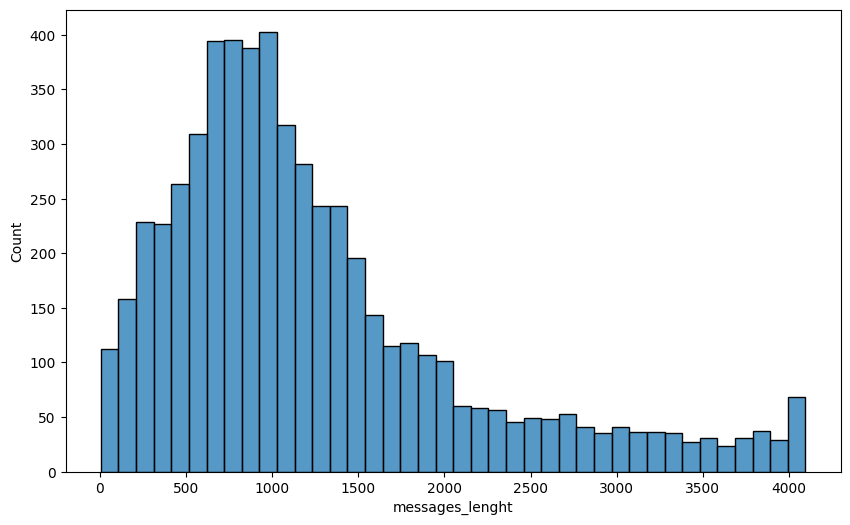

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['message_lenght'])
plt.xlabel("messages_lenght")

Text(0.5, 0, 'Count of words')

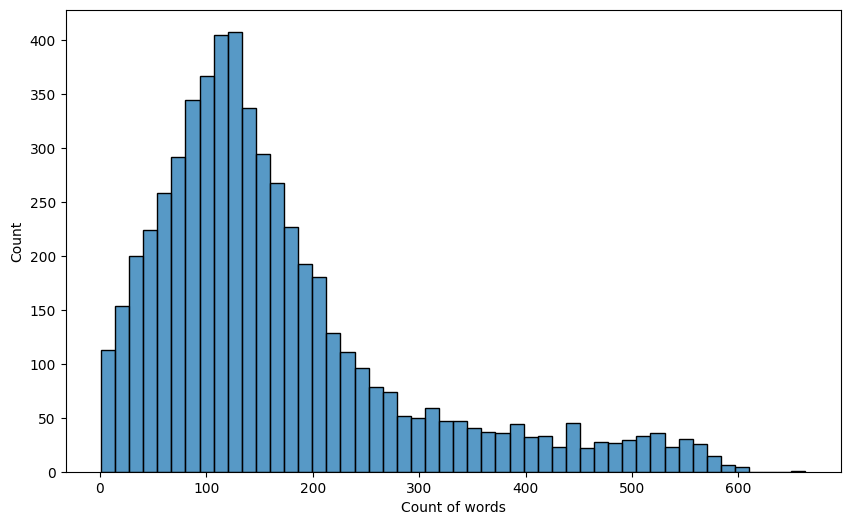

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['word_count'])
plt.xlabel("Count of words")

**Удалим слишком короткие и слишком длинные сообщения**

In [17]:
filtered_df = df[df['word_count'] <= 400].copy()

filtered_df = filtered_df[
    (filtered_df['message_lenght']) >= 20 & 
    (filtered_df['message_lenght'] <= 2000)
]
    
print(f"После фильтрации: {len(filtered_df)} сообщений")
print(f"Удалено: {len(df) - len(filtered_df)} сообщений")

После фильтрации: 5173 сообщений
Удалено: 409 сообщений


**Предобработка текстов**

In [19]:
'наш' in extra_stopwords

True

In [ ]:
# создаём морфологический анализатор
morph = pymorphy3.MorphAnalyzer()

if 'russian_stopwords' not in locals():
      russian_stopwords = stopwords.words("russian")

extra_stopwords = {'наш', 'свой', 'который', 'это', 'весь', 'сам'}

texts_as_lists = []

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower() # Приведение к нижнему регистру
        text = text.lower()
        text = re.sub(r'[^а-яё]', ' ', text) # Удаление пунктуации, кроме пробелов
        # разбиваем на слова
        words = text.split()
        # приводим к леммам, убираем стоп-слова и короткие слова (это важно для тематическго моделирования)
        lemmas = [morph.parse(word)[0].normal_form for word in words if 
                  word not in russian_stopwords and 
                  morph.parse(word)[0].normal_form not in extra_stopwords and 
                  len(word) > 2]
        texts_as_lists.append(lemmas)
        return " ".join(lemmas)
    return "" # Возвращаем пустую строку для нестроковых значений


print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'message' in filtered_df.columns:
    tqdm.pandas()
    filtered_df['processed_text'] = filtered_df['message'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(filtered_df.head())


Начало предобработки текста...


100%|██████████| 5173/5173 [00:46<00:00, 111.57it/s]

Предобработка текста завершена.


,message,message_lenght,word_count,processed_text
0,"Поздравляем, самые любимые 💙\n\nВы научили нас...",399,62,поздравлять самый любимый научить смотреть мир...
1,☀️ Как победить сезонную хандру? \n\nУчастники...,784,155,победить сезонный хандра участник аэрофлот бон...
2,👦На борту наших рейсов юные пассажиры ведут се...,767,121,борт рейс юный пассажир вести образцово всё пр...
3,❄️ Только представьте: полёт в сопровождении о...,603,83,представить полёт сопровождение оркестр борт р...
4,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...,943,186,пока составлять список подарок новогодний праз...


**Облако слов**

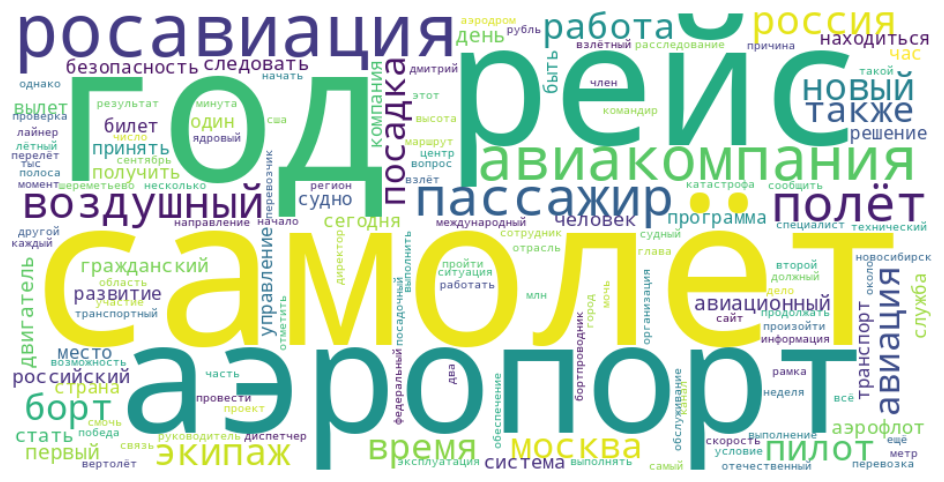

In [21]:
def create_wordcloud(texts, max_words=100):
    # Объединяем все тексты
    all_text = ' '.join(texts)
    
    # Создаем облако слов
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        collocations=False
    ).generate(all_text)
    
    # Отображаем
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return wordcloud


wordcloud = create_wordcloud(filtered_df['processed_text'], max_words=150)

In [22]:
filtered_df['processed_text'].to_csv('../data/processed/cleaned_posts_v1.csv', index=False)